In [1]:
# requirement
!pip install akshare
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install scikit-learn
!pip install tensorflow


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached tensorflow-2.16.1-cp311-cp311-win_amd64.whl.metadata (3.5 kB)
  Using cached tensorflow_intel-2.16.1-cp311-cp311-win_amd64.whl.metadata (5.0 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached gast-0.5.4-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached h5py-3.11.0-cp311-cp311-win_amd64.whl.metadata (2.5 kB)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached ml_dtypes-0.3.2-cp311-cp311-win_amd64.whl.metadata (20 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached protobuf-4.25.3-cp310-abi3-win_amd64.whl.metadata (541 bytes)
  Using cached termcolor-2.4.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached typing_extensions-4.11.0-py3-none-any.whl.metadat


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



   ------------ --------------------------- 118.2/377.0 MB 1.5 MB/s eta 0:02:59
   ------------ --------------------------- 118.3/377.0 MB 1.4 MB/s eta 0:02:59
   ------------ --------------------------- 118.3/377.0 MB 1.5 MB/s eta 0:02:58
   ------------ --------------------------- 118.4/377.0 MB 1.5 MB/s eta 0:02:58
   ------------ --------------------------- 118.5/377.0 MB 1.5 MB/s eta 0:02:57
   ------------ --------------------------- 118.5/377.0 MB 1.5 MB/s eta 0:02:55
   ------------ --------------------------- 118.7/377.0 MB 1.5 MB/s eta 0:02:56
   ------------ --------------------------- 118.7/377.0 MB 1.5 MB/s eta 0:02:56
   ------------ --------------------------- 118.8/377.0 MB 1.5 MB/s eta 0:02:56
   ------------ --------------------------- 118.8/377.0 MB 1.5 MB/s eta 0:02:57
   ------------ --------------------------- 118.8/377.0 MB 1.5 MB/s eta 0:02:57
   ------------ --------------------------- 118.9/377.0 MB 1.5 MB/s eta 0:02:56
   ------------ -----------------------

#### Reading Stocks

In [2]:
# loading packages (pip/pip3 list for new packages) - https://github.com/akfamily/akshare
# pip install akshare --upgrade
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import akshare as ak 

# plt.rcParams['font.sans-serif'] = 'Arial Unicode MS' #显示中文 Windows
plt.rcParams['font.sans-serif'] = ['Simhei']  #显示中文 Mac
plt.rcParams['axes.unicode_minus'] = False 

In [4]:
df_raw = ak.stock_zh_a_spot()
df_raw.columns

df = df_raw[['代码','名称']].copy()
df.rename(columns={'代码': 'symbol', '名称': 'name'}, inplace=True)
symbol_name_dict = df.set_index('symbol')['name'].to_dict()
# symbol_name_dict.get('sh600029')

# 将字典转换为DataFrame
df_symbols = pd.DataFrame(list(symbol_name_dict.items()), columns=['symbol', 'name'])

# 将DataFrame存储为CSV文件
df_symbols.to_csv('symbol_name_dict.csv', index=False)

Index(['代码', '名称', '最新价', '涨跌额', '涨跌幅', '买入', '卖出', '昨收', '今开', '最高', '最低',
       '成交量', '成交额', '时间戳'],
      dtype='object')

In [7]:
# 从CSV文件读取DataFrame
df_dict = pd.read_csv('symbol_name_dict.csv')

# 将DataFrame转换回字典
symbol_name_dict_loaded = df_dict.set_index('symbol')['name'].to_dict()

# 测试重新加载的字典
print(symbol_name_dict_loaded.get('sh600029'))

南方航空


In [8]:
start_date = "2023-06-01"
end_date = datetime.now().date().strftime("%Y-%m-%d")
stock_list = ['sh600887','sh600754','sh600009','sh601318','sh601127','sh600900'] # 'sz000651' 格力

def get_signal(stock_index):

    stock_data = ak.stock_zh_a_daily(symbol=stock_index, start_date=start_date, end_date=end_date)
    # 计算5日和20日均线
    stock_data["ma5"] = stock_data["close"].rolling(window=5).mean()
    stock_data["ma20"] = stock_data["close"].rolling(window=20).mean()
    # 生成买入/卖出信号（ma5向上穿越ma20/ma5向下穿越ma20）
    stock_data["buy_signal"] = (stock_data["ma5"] > stock_data["ma20"]) & (stock_data["ma5"].shift(1) <= stock_data["ma20"].shift(1))
    stock_data["sell_signal"] = (stock_data["ma5"] < stock_data["ma20"]) & (stock_data["ma5"].shift(1) >= stock_data["ma20"].shift(1))

    return stock_data

##### Visualisation

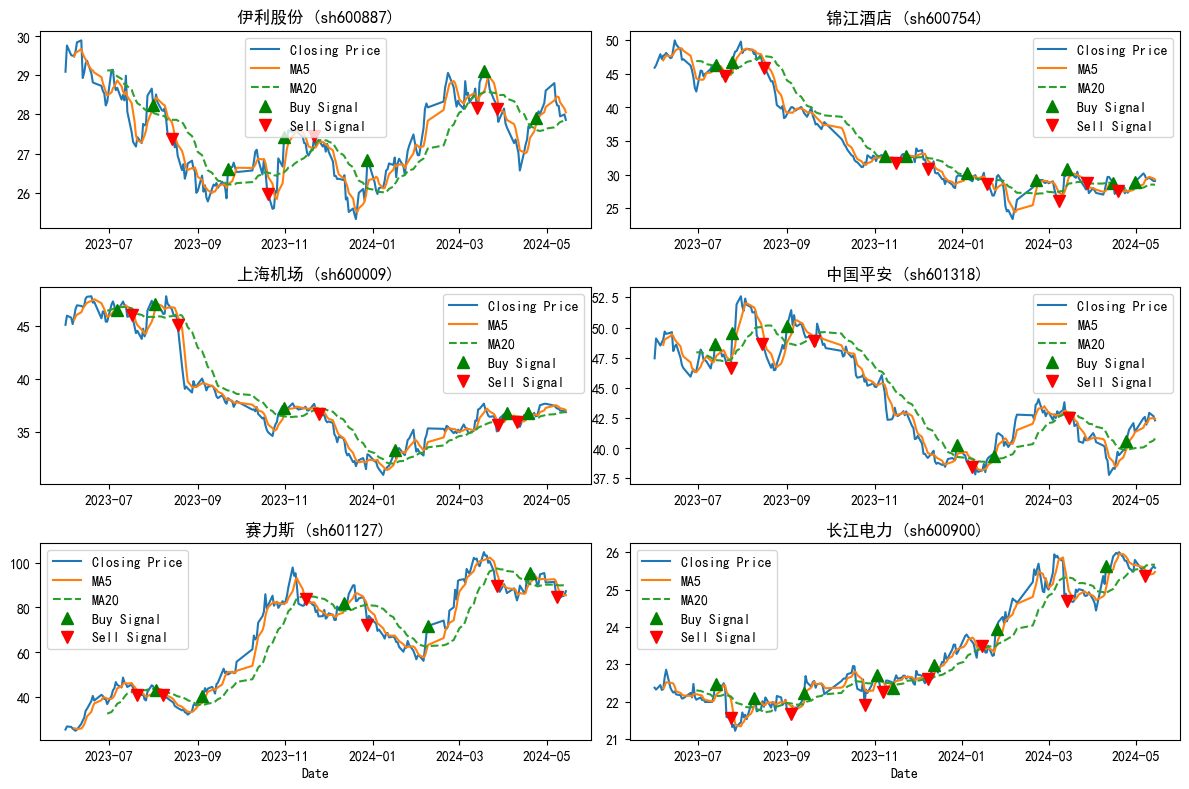

In [9]:
# Create a figure and axes for the subplots
fig, axs = plt.subplots(3, 2, figsize=(12, 8))  # 3 rows, 2 columns

for i, stock_index in enumerate(stock_list):
    stock_data = get_signal(stock_index)
    stock_name = symbol_name_dict.get(stock_index)
    # print(f'{stock_name}: {stock_index}\n')
    
    # Calculate the subplot position
    row = i // 2  # Determine the row index
    col = i % 2   # Determine the column index
    
    # Retrieve the corresponding subplot axes
    ax = axs[row, col]

    # Convert the index into datetime
    stock_data.index = pd.to_datetime(stock_data['date'], format='%Y-%m-%d')
    
    # Plot the closing prices
    ax.plot(stock_data.index, stock_data["close"], label="Closing Price")
    
    # Plot the moving averages (ma5 and ma20)
    ax.plot(stock_data.index, stock_data["ma5"], linestyle='-', label="MA5")
    ax.plot(stock_data.index, stock_data["ma20"], linestyle='--', label="MA20")
    
    # Plot the buy and sell signals
    ax.plot(stock_data[stock_data['buy_signal']]['date'], stock_data[stock_data['buy_signal']]['close'], 'g^', markersize=8, label='Buy Signal')
    ax.plot(stock_data[stock_data['sell_signal']]['date'], stock_data[stock_data['sell_signal']]['close'], 'rv', markersize=8, label='Sell Signal')

    # Set the subplot title and legend
    ax.set_title(f"{stock_name} ({stock_index})")
    ax.legend()
    
    # Set the x-axis label only for the bottom subplots
    if row == 2:
        ax.set_xlabel("Date")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

In [10]:
stock_data = ak.stock_zh_a_daily(symbol=stock_list[3], start_date=start_date, end_date=end_date)
# 将日期列设置为索引
stock_data.set_index('date', inplace=True)
stock_data

,open,high,low,close,volume,amount,outstanding_share,turnover
date,,,,,,,,
2023-06-01,47.05,47.93,46.90,47.45,51807430.0,2.460498e+09,1.083266e+10,0.004783
2023-06-02,47.88,49.20,47.83,49.10,83284040.0,4.054041e+09,1.083266e+10,0.007688
2023-06-05,48.76,48.93,48.23,48.51,46645590.0,2.261940e+09,1.083266e+10,0.004306
2023-06-06,48.34,49.93,48.25,48.76,64450197.0,3.172322e+09,1.083266e+10,0.005950
2023-06-07,49.40,49.69,48.77,49.01,42543624.0,2.093898e+09,1.083266e+10,0.003927
...,...,...,...,...,...,...,...,...
2024-05-08,42.45,42.70,41.88,41.95,44733513.0,1.888702e+09,1.076266e+10,0.004156
2024-05-09,41.87,42.58,41.86,42.34,41354149.0,1.749775e+09,1.076266e+10,0.003842
2024-05-10,42.60,43.18,42.52,42.93,67767018.0,2.906706e+09,1.076266e+10,0.006296


#### Modeling

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 划分训练集和测试集
X = stock_data.drop('close', axis=1)
y = stock_data['close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
# 训练回归模型
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# 训练决策树模型
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

# 训练随机森林模型
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# 计算均方误差
mse_lr = mean_squared_error(y_test, y_pred_lr)
mse_dt = mean_squared_error(y_test, y_pred_dt)
mse_rf = mean_squared_error(y_test, y_pred_rf)

print('回归模型的均方误差：', mse_lr)
print('决策树模型的均方误差：', mse_dt)
print('随机森林模型的均方误差：', mse_rf)

回归模型的均方误差： 0.02003412116785291
决策树模型的均方误差： 0.19320652173913033
随机森林模型的均方误差： 0.13712945347825886


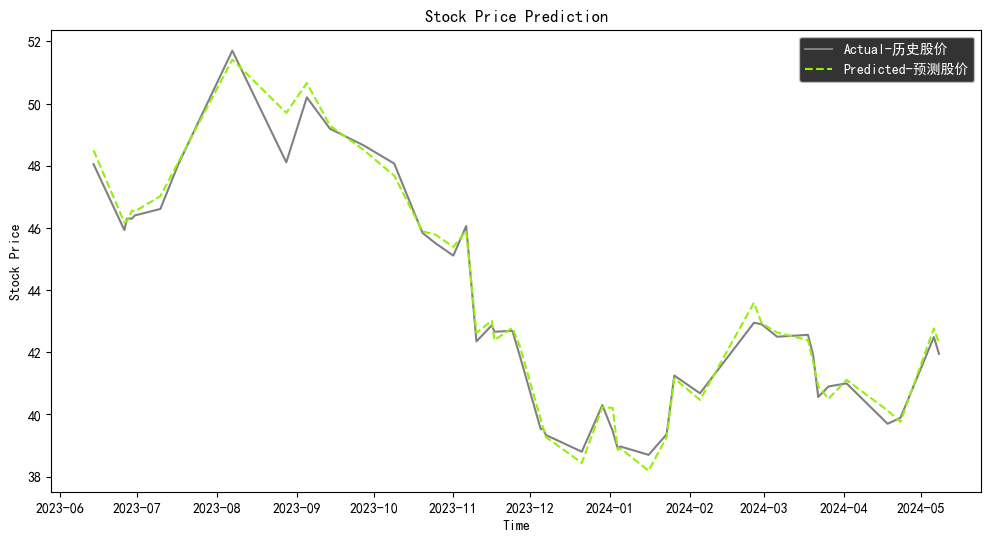

In [45]:

dates = y_test.index[:len(y_pred_rf)]
# y_test.index = pd.to_datetime(y_test.index)
y_test = pd.DataFrame(y_test)
y_test['predict'] = y_pred_rf
y_test.sort_index(inplace=True)

# Plot the predicted and actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test['close'], label="Actual-历史股价", color="grey")
plt.plot(y_test['predict'], label="Predicted-预测股价", color="#94F008", linestyle = "--")
plt.title("Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend(facecolor='black', labelcolor='white')
plt.show()

In [55]:
y_test

,close,Predict
date,,
2024-03-29,87.00,87.5397
2024-04-18,91.78,92.9115
2023-12-22,84.06,84.3393
2024-02-26,80.05,79.5625
2023-06-26,40.92,41.6765
2023-11-15,83.59,82.3659
2024-03-04,92.65,91.5239
2023-09-14,45.61,43.3010
2024-04-08,88.55,87.3008


#### Modelling - LSTM

In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras import regularizers

In [44]:
stock_data = ak.stock_zh_a_daily(symbol=stock_list[1], start_date=start_date, end_date=end_date)
# Convert the date column to datetime format
stock_data["date"] = pd.to_datetime(stock_data["date"])
stock_data["day_of_year"] = stock_data["date"].dt.dayofyear

# Sort the data by date in ascending order
stock_data.sort_values("date", inplace=True)

# Normalize the closing price values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
stock_data["close_scaled"] = scaler.fit_transform(stock_data["close"].values.reshape(-1, 1))

##### Training

In [46]:
# Split the data into training and testing sets
train_size = int(len(stock_data) * 0.7)
train_data = stock_data[:train_size]
test_data = stock_data[train_size:]

# Create input sequences and corresponding target values for training
X_train = []
y_train = []

# Define the number of previous time steps to consider
# (e.g., use the previous 10 days' closing prices to predict the next day)
time_steps = 10

for i in range(time_steps, len(train_data)):
    X_train.append(train_data["close_scaled"].values[i - time_steps:i])
    y_train.append(train_data["close_scaled"].values[i])

# Convert the lists to NumPy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

# Reshape the input data to match the LSTM layer input shape
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Create input sequences and corresponding target values for testing
X_test = []
y_test = []

for i in range(time_steps, len(test_data)):
    X_test.append(test_data["close_scaled"].values[i - time_steps:i])
    y_test.append(test_data["close_scaled"].values[i])

# Convert the lists to NumPy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)

# Reshape the input data to match the LSTM layer input shape
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [48]:
# Initialize the model
model = Sequential()

# Add an LSTM layer with 50 units
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, 1)))

# Add another LSTM layer with 50 units
model.add(LSTM(units=50))

# Add a dense output layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")
# print(model.summary())

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5270
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3168 
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1338 
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0203 
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0390 
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0319 
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0113 
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0181 
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0197 
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0112 
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0089 
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0107 
Epoch 13/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0101 
Epoch 14/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0085 
Epoch 15/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0077 
Epoch 16/50
4/4 ━━━━━━━━━━━━━━━━━━━

##### Model Prediction - LSTM

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


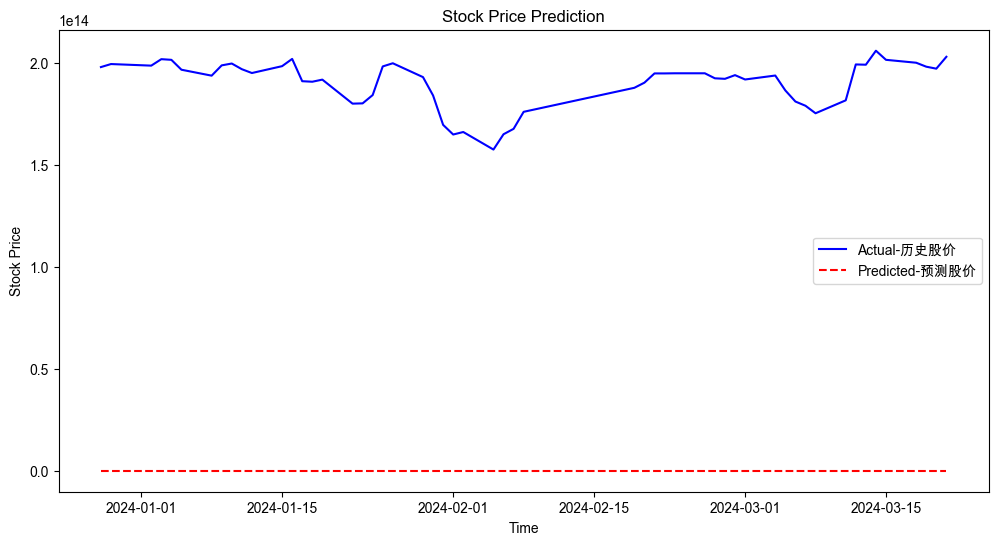

In [33]:
# Generate predictions for the test set
y_pred = model.predict(X_test)

# Rescale the predicted and actual values back to their original range
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
y_date = test_data[time_steps:]["date"]

# Plot the predicted and actual values
plt.figure(figsize=(12, 6))
plt.plot(y_date, y_test, label="Actual-历史股价", color="blue")
plt.plot(y_date, y_pred, label="Predicted-预测股价", color="red", linestyle = "--")
plt.title("Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

In [67]:
# Finalizing predictions
y_pred = model.predict(X_test)

# Rescale the predicted and actual values back to their original range
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
y_date = test_data[time_steps:]["date"]

test_preds_df = pd.DataFrame(
    y_test, columns=[f'pred_{i+1}_step' for i in range(y_test.shape[1])])
test_preds_df['true_value'] = test_data['close_scaled'].values[-len(y_pred):]
test_preds_df['naive_pred'] = test_data['close_scaled'].values[-len(y_pred) - 1:-1]

test_preds_df['pred_1_step'] = pd.to_numeric(test_preds_df['pred_1_step'])
test_preds_df['true_value'] = pd.to_numeric(test_preds_df['true_value'])
err = mean_absolute_error(test_preds_df['pred_1_step'].values,test_preds_df['true_value'].values)
#err = mean_squared_error(test_preds_df['pred_1_step'].values,test_preds_df['true_value'].values)
print(f'abs error for testset is {err}')



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
abs error for testset is 9.337806437354897e+19


In [71]:
test_preds_df

,pred_1_step,true_value,naive_pred
0,9.705761e+19,0.228216,0.256507
1,9.562034e+19,0.211241,0.228216
2,9.811161e+19,0.240664,0.211241
3,9.855876e+19,0.245945,0.240664
4,9.718537e+19,0.229725,0.245945
5,9.625913e+19,0.218785,0.229725
6,9.791997e+19,0.238401,0.218785
7,9.967664e+19,0.259147,0.238401
8,9.427889e+19,0.195398,0.259147
9,9.415113e+19,0.193889,0.195398


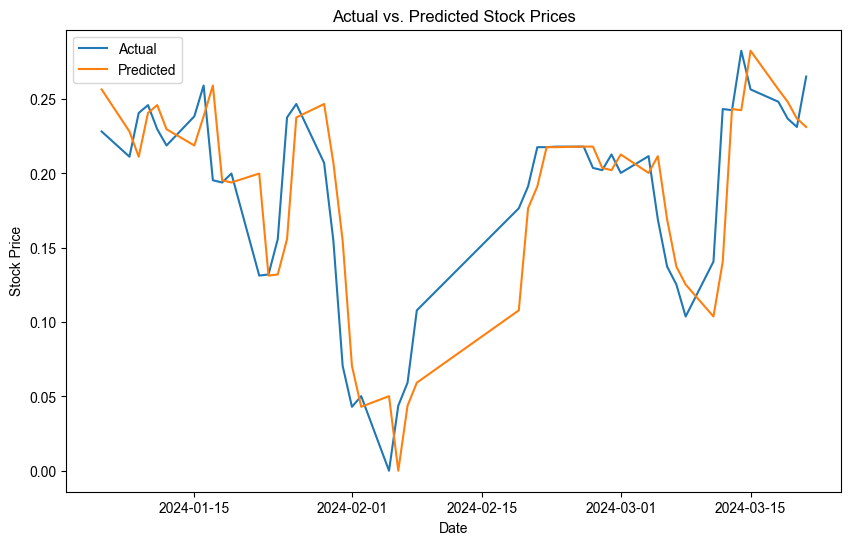

In [72]:
plt.figure(figsize=(10, 6))
plt.plot(y_date, test_preds_df['true_value'], label='Actual')
plt.plot(y_date, test_preds_df['naive_pred'], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Actual vs. Predicted Stock Prices')
plt.legend()
plt.show()